import needed library and declare list of category column

In [1]:

import csv
import pandas as pd
import numpy as np
import random
import nltk
import matplotlib.pyplot as plt
from nltk.tokenize import wordpunct_tokenize
from collections import defaultdict
from nltk.probability import FreqDist
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
crawledDataSetNames = ['dataset-reddit-business.csv', 'dataset-reddit-entertainment.csv', 
'dataset-reddit-parenting.csv', 'dataset-reddit-politics.csv', 
'dataset-reddit-sports.csv', 'dataset-reddit-travel.csv']

categories = ['business', 'entertainment', 'parenting', 'politics', 'sports', 'travel']




preprocessing function

In [2]:
def preprocessing(originData):
    data = originData.copy()
    #make all characters to lower case
    data['text']=data['text'].apply(lambda x: str.lower(x))

    #word tokenization
    data['text'] = data['text'].apply(lambda x: wordpunct_tokenize(x))

    #delete non alphabets word
    data['text'] = data['text'].apply(lambda x: list(word for word in x if word.isalpha()))

    print('preprocessing finished. 1 / 6')
    return data

declare making word dictionary function and making Bag Of words Column function.

In [3]:
def makingWordDict(originData):
    data = originData.copy()
    listedText=data['text'].tolist()
    allTextList = []
    for l in listedText:
        allTextList.extend(l)
    numOfdict = len(set(allTextList))
    
    numOfFeatureWords = int(numOfdict*1)

    fdist = FreqDist(allTextList)

    wordDict = list(word for word, freq in fdist.most_common(numOfFeatureWords))

    print('making word dictionary finished. 2 / 6')
    return wordDict

def makingBagOfWordsCol(originData, wordDict):
    data = originData.copy()
    def bagOfWords(tokens):
        d = defaultdict(int,{ word:0 for word in wordDict })

        for token in tokens:
            d[token]+=1

        return list(d.values())[:len(wordDict)]

    data['bagOfWords'] = data['text'].apply(lambda x: bagOfWords(x))

    print('making bag of words column finished. 3 / 6')
    return data

declare divide trainset and testset function.

In [4]:
def divideTrainAndTest(originData):
    data = originData.copy()
    dataSize = data.shape[0]

    trainSplit = 0.7
    testSplit = 0.3

    trainSize = int(dataSize * trainSplit)
    testSize = int(dataSize * testSplit)

    print('trainSize: ', trainSize)
    print('testSize: ', testSize)

    trainSet = data.iloc[:trainSize, :]
    testSet = data.iloc[trainSize:, :]

    print('dividing train and test set finished. 4 / 6')
    return trainSet, testSet

declare build a Bag of Words model and fit by using train set.

In [5]:
def buildAndFitModel(trainSet):
    classifier = MultinomialNB()
    trainX = np.array(trainSet['bagOfWords'].tolist())
    trainY = np.array(trainSet['category'].tolist())
    
    classifier.fit(trainX, trainY)

    print('building and fitting the model finished. 5 / 6')
    return classifier

declare evaluate function.

In [6]:
def evaluate(classifier, testSet):
    testX = np.array(testSet['bagOfWords'].tolist())
    testY = np.array(testSet['category'].tolist())
    
    predY = classifier.predict(testX)
    predYProb = classifier.predict_proba(testX)
    evalTable = classification_report(testY, predY)
    print('evaluating the model finished. 6 / 6')
    print('-confusion matrix-\n')
    cm = confusion_matrix(testY, predY, labels=categories)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
    disp.plot()
    plt.show()
    return evalTable, predYProb

1. read the crawled Dataset of reddit.

In [7]:
rawRedditDataset = pd.DataFrame(columns = {'text','category'})
for crawledDataSetName in crawledDataSetNames:
    #read csv files
    df = pd.read_csv('./dataset/%s'%crawledDataSetName)
    
    #replace Nan to empty string
    df = df.fillna('')

    #'titleAndContent' Column is concat of 'title' and 'content'
    df['text']=df['title']+' '+df['content']
    rawRedditDataset = pd.concat([rawRedditDataset, df[['text', 'category']]])

rawRedditDataset=rawRedditDataset[['text', 'category']]
#shuffle row
rawRedditDataset=rawRedditDataset.sample(frac=1).reset_index(drop=True)

print(rawRedditDataset)

                                                   text       category
0     ‘The Simpsons’ Rips Fox News, Tucker Carlson A...  entertainment
1                    Went to Chornobyl this weekend #1          travel
2     ‘The Simpsons’ Family Raises The Ukrainian Fla...  entertainment
3     Kimi Raikkonen to make racing return in NASCAR...         sports
4     Federal judge rules Kim Davis violated couples...       politics
...                                                 ...            ...
5936  Opinion: Should one millionaire senator really...       politics
5937  'Karen' who slapped Delta passenger is ex-'Bay...  entertainment
5938  Andrew Garfield Wants More ‘Spider-Man’ Films ...  entertainment
5939  Texas border bridge lost $1 billion during gov...       business
5940                       A week in Seville, Spain 🇪🇸          travel

[5941 rows x 2 columns]


2. read the news category dataset(from kaggle).

In [8]:
originNewsCategory = ['BUSINESS', 'ENTERTAINMENT', 'PARENTING', 'POLITICS', 'SPORTS', 'TRAVEL']

rawNewsDataset = pd.read_json("./dataset/News_category_Dataset_v2.json", lines=True)
rawNewsDataset = rawNewsDataset[rawNewsDataset['category'].isin(originNewsCategory)]
rawNewsDataset = rawNewsDataset.groupby('category').sample(n=2000)
rawNewsDataset['category'] = rawNewsDataset['category'].apply(lambda x: x.lower())

rawNewsDataset['text'] = rawNewsDataset['headline'] + ' ' + rawNewsDataset['short_description']
rawNewsDataset = rawNewsDataset[['text','category']]

#shuffle row
rawNewsDataset=rawNewsDataset.sample(frac=1).reset_index(drop=True)

print(rawNewsDataset)

                                                    text       category
0      Banks’ Embrace of Jumbo Mortgages Means Fewer ...       business
1      A Firm Grasp On Comfort “Where’s your baby?” s...      parenting
2      People Are Convinced This Is The Moment Britne...  entertainment
3      David Beckham And Kevin Hart Spotted Twinning ...  entertainment
4      Adam Driver Remembers His 'Star Wars' Mom, Car...  entertainment
...                                                  ...            ...
11995  Charles Barkley Believes Kevin Durant Is Tryin...         sports
11996  This Former College Football Player Is Lifting...         sports
11997  Back-to-School Blues: A Family Affair While fo...      parenting
11998  Prayer for My Son on His 16th Birthday Bills a...      parenting
11999  12 Women Who Absolutely Killed The Sports Game...         sports

[12000 rows x 2 columns]


3. the model only using reddit crawled dataset.

preprocessing finished. 1 / 6
making word dictionary finished. 2 / 6
making bag of words column finished. 3 / 6
trainSize:  4158
testSize:  1782
dividing train and test set finished. 4 / 6
building and fitting the model finished. 5 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



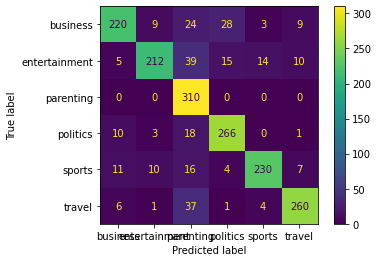

only reddit dataset model classification report
                precision    recall  f1-score   support

     business       0.87      0.75      0.81       293
entertainment       0.90      0.72      0.80       295
    parenting       0.70      1.00      0.82       310
     politics       0.85      0.89      0.87       298
       sports       0.92      0.83      0.87       278
       travel       0.91      0.84      0.87       309

     accuracy                           0.84      1783
    macro avg       0.86      0.84      0.84      1783
 weighted avg       0.86      0.84      0.84      1783



In [9]:
redditDataset = preprocessing(rawRedditDataset)
redditWordDict = makingWordDict(redditDataset)
BOWredditDataset = makingBagOfWordsCol(redditDataset, redditWordDict)

redditTrainSet, redditTestSet = divideTrainAndTest(BOWredditDataset)

redditClassifier = buildAndFitModel(redditTrainSet)

redditEvalTable, redditPredYProb = evaluate(redditClassifier, redditTestSet)

print('only reddit dataset model classification report\n', redditEvalTable)

4. the model only using news dataset.

preprocessing finished. 1 / 6
making word dictionary finished. 2 / 6
making bag of words column finished. 3 / 6
trainSize:  8400
testSize:  3600
dividing train and test set finished. 4 / 6
building and fitting the model finished. 5 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



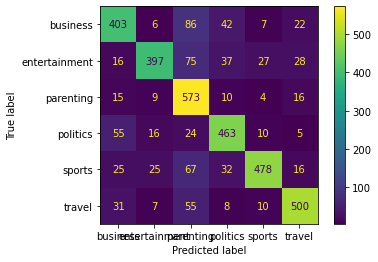

only news dataset model classification report
                precision    recall  f1-score   support

     business       0.74      0.71      0.73       566
entertainment       0.86      0.68      0.76       580
    parenting       0.65      0.91      0.76       627
     politics       0.78      0.81      0.79       573
       sports       0.89      0.74      0.81       643
       travel       0.85      0.82      0.83       611

     accuracy                           0.78      3600
    macro avg       0.80      0.78      0.78      3600
 weighted avg       0.80      0.78      0.78      3600



In [10]:
newsDataset = preprocessing(rawNewsDataset)
newsWordDict = makingWordDict(newsDataset)
BOWnewsDataset = makingBagOfWordsCol(newsDataset, newsWordDict)

newsTrainSet, newsTestSet = divideTrainAndTest(BOWnewsDataset)

newsClassifier = buildAndFitModel(newsTrainSet)

newsEvalTable, newsPredYProb = evaluate(newsClassifier, newsTestSet)

print('only news dataset model classification report\n', newsEvalTable)

5. the model using both reddit and news datasets.

preprocessing finished. 1 / 6
making word dictionary finished. 2 / 6
making bag of words column finished. 3 / 6
trainSize:  12558
testSize:  5382
dividing train and test set finished. 4 / 6
building and fitting the model finished. 5 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



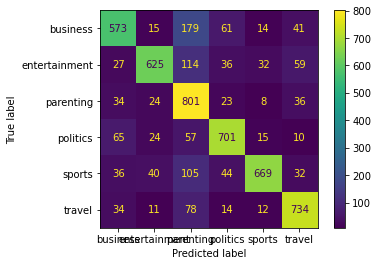

using both reddit and both dataset model classification report
                precision    recall  f1-score   support

     business       0.75      0.65      0.69       883
entertainment       0.85      0.70      0.77       893
    parenting       0.60      0.87      0.71       926
     politics       0.80      0.80      0.80       872
       sports       0.89      0.72      0.80       926
       travel       0.80      0.83      0.82       883

     accuracy                           0.76      5383
    macro avg       0.78      0.76      0.76      5383
 weighted avg       0.78      0.76      0.76      5383



In [11]:
rawBothDataset = pd.concat([rawRedditDataset, rawNewsDataset])

bothDataset = preprocessing(rawBothDataset)
bothWordDict = makingWordDict(bothDataset)
BOWbothDataset = makingBagOfWordsCol(bothDataset, bothWordDict)

bothTrainSet, bothTestSet = divideTrainAndTest(BOWbothDataset)

bothClassifier = buildAndFitModel(bothTrainSet)

bothAccuracy, bothPredYProb = evaluate(bothClassifier, bothTestSet)

print('using both reddit and both dataset model classification report\n', bothAccuracy)

6. predict category of reddit testset by the model only trained by news train set.

making bag of words column finished. 3 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



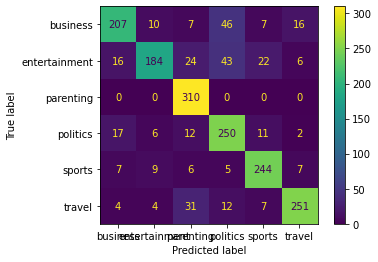

predicting the category of reddit test set on news-trained model classification report
                precision    recall  f1-score   support

     business       0.82      0.71      0.76       293
entertainment       0.86      0.62      0.72       295
    parenting       0.79      1.00      0.89       310
     politics       0.70      0.84      0.76       298
       sports       0.84      0.88      0.86       278
       travel       0.89      0.81      0.85       309

     accuracy                           0.81      1783
    macro avg       0.82      0.81      0.81      1783
 weighted avg       0.82      0.81      0.81      1783



In [12]:
BOWredditTestsetUsingNewsWordDict = makingBagOfWordsCol(redditTestSet, newsWordDict)

redditOnNewsEvalTable, redditOnNewsPredYProb = evaluate(newsClassifier, BOWredditTestsetUsingNewsWordDict)

print('predicting the category of reddit test set on news-trained model classification report\n', redditOnNewsEvalTable)


7. predict category of news testset by the model only trained by reddit train set.

making bag of words column finished. 3 / 6
evaluating the model finished. 6 / 6
-confusion matrix-



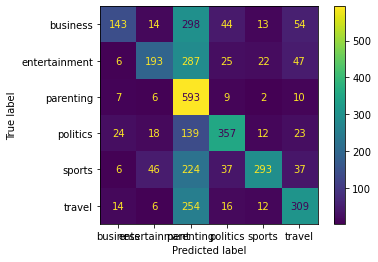

predicting the category of reddit test set on news-trained model classification report
                precision    recall  f1-score   support

     business       0.71      0.25      0.37       566
entertainment       0.68      0.33      0.45       580
    parenting       0.33      0.95      0.49       627
     politics       0.73      0.62      0.67       573
       sports       0.83      0.46      0.59       643
       travel       0.64      0.51      0.57       611

     accuracy                           0.52      3600
    macro avg       0.66      0.52      0.52      3600
 weighted avg       0.65      0.52      0.52      3600



In [13]:
BOWnewsTestsetUsingRedditWordDict = makingBagOfWordsCol(newsTestSet, redditWordDict)

newsOnRedditEvalTable, newsOnRedditPredYProb = evaluate(redditClassifier, BOWnewsTestsetUsingRedditWordDict)

print('predicting the category of reddit test set on news-trained model classification report\n', newsOnRedditEvalTable)
